# Importing libraries

In [120]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import treebank
nltk.download('treebank')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Prepare 

## Read each line in train/test file and split word and its part-of-speech by '/' seperator

In [121]:
def readData(filePath):
    with open(filePath, 'r', encoding='utf8') as f:
        file = f.read().splitlines()
    data = [[] for _ in range(len(file))]
    for idx, i in enumerate(file):
        sentence = i[4:]
        a = sentence.split()
        data[idx].append(('', '<s>'))
        for j in a:
            tmp = (j.rsplit('/',1))
            data[idx].append((tmp[0], tmp[1]))
    return data

In [122]:
trainData = readData('/content/drive/MyDrive/CS221/data/rawData/train50.txt')
testData = readData('/content/drive/MyDrive/CS221/data/rawData/test50.txt')

In [123]:
def func(data):
    corpusData = []
    posData = []
    for sentence in data:
        tempCorpus = []
        tempPos = []
        for pair in sentence:
            if pair[0] != '':
                tempCorpus.append(pair[0])
                tempPos.append(pair[1])
        corpusData.append(tempCorpus)
        posData.append(tempPos)
    return (corpusData,posData)

In [124]:
trainCorpusData, trainPosData = func(trainData)
testCorpusData, testPosData = func(testData)

In [125]:
trainPosDataWithS = list()
for i in trainPosData:
    i = ['<s>'] + i
    trainPosDataWithS.append(i)

## Create list of train and test tagged words

In [126]:
trainTagged = [tup for sent in trainData for tup in sent]

## Check how many unique tags are present in training data

In [127]:
tags = list({tag for word,tag in trainTagged})
tags.remove('<s>')
fullTags = tags.copy()
fullTags.append('<s>')
unique_tags = len(fullTags)

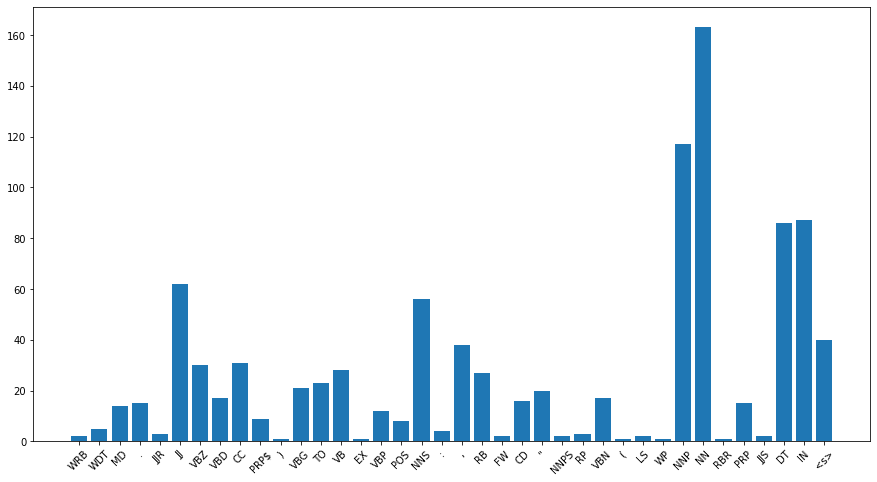

In [128]:
countTags = {i:0 for i in fullTags}
for i in trainTagged:
    pos = i[1]
    countTags[pos] += 1
plt.rcParams["figure.figsize"] = (15,8)
plt.bar(range(len(countTags)), list(countTags.values()), align='center')
plt.xticks(range(len(countTags)), list(countTags.keys()))
plt.xticks(rotation=45)
plt.show()

## Check how many words are present in vocabulary

In [129]:
vocab = {word for word,tag in trainTagged if word != ''}
print(len(vocab))

534


# HMM

## Compute transition matrix

In [130]:
#Compute transition probabilities of a previous and next tag
def t2_given_t1(t2,t1,train_tags=trainPosDataWithS):
    # Find t1
    t1Tags = 0
    for sent in train_tags:
        for i in range(len(sent)):
            if sent[i] == t1:
                t1Tags += 1


    # Find t2 given t1
    t2GivenT1 = 0

    for sent in train_tags:
        for i in range(len(sent)-1):
            if sent[i] == t1 and sent[i+1] == t2:
                t2GivenT1 += 1


    # Use smoothing to prevent zero probability
    t1Count = t1Tags + unique_tags
    countT2GivenT1 = t2GivenT1 + 1


    if t2 == '<s>': return (0,1)
    else: return (countT2GivenT1, t1Count)

In [131]:
tags_matrix = np.zeros((len(fullTags), len(fullTags)), dtype='float32')
for i, t1 in enumerate(list(fullTags)):
    for j, t2 in enumerate(list(fullTags)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix = pd.DataFrame(tags_matrix, columns = list(fullTags), index=list(fullTags))
tags_matrix = tags_matrix.to_numpy()

# tags_matrix = np.log(tags_matrix)

In [132]:
# Convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(fullTags), index=list(fullTags))
tags_df=tags_df.drop('<s>', axis=1)
tags_df


,WRB,WDT,MD,.,JJR,JJ,VBZ,VBD,CC,PRP$,...,(,LS,WP,NNP,NN,RBR,PRP,JJS,DT,IN
WRB,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.050000,0.025000,0.025000,0.025000
WDT,0.023256,0.023256,0.046512,0.023256,0.023256,0.023256,0.069767,0.046512,0.023256,0.023256,...,0.023256,0.023256,0.023256,0.023256,0.023256,0.023256,0.023256,0.023256,0.023256,0.023256
MD,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,...,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231
.,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,...,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868,0.018868
JJR,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,...,0.024390,0.024390,0.024390,0.024390,0.048780,0.024390,0.024390,0.024390,0.024390,0.024390
JJ,0.010000,0.010000,0.010000,0.010000,0.010000,0.040000,0.010000,0.010000,0.030000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.340000,0.010000,0.010000,0.010000,0.010000,0.010000
VBZ,0.014706,0.014706,0.014706,0.014706,0.014706,0.044118,0.014706,0.044118,0.014706,0.029412,...,0.014706,0.014706,0.014706,0.014706,0.014706,0.014706,0.014706,0.014706,0.161765,0.058824
VBD,0.018182,0.018182,0.018182,0.018182,0.018182,0.036364,0.018182,0.018182,0.036364,0.018182,...,0.018182,0.018182,0.018182,0.036364,0.054545,0.018182,0.036364,0.018182,0.072727,0.090909
CC,0.014493,0.028986,0.014493,0.014493,0.014493,0.057971,0.028986,0.028986,0.014493,0.014493,...,0.014493,0.014493,0.014493,0.086957,0.115942,0.014493,0.072464,0.014493,0.014493,0.014493
PRP$,0.021277,0.021277,0.021277,0.021277,0.021277,0.042553,0.021277,0.021277,0.021277,0.021277,...,0.021277,0.021277,0.021277,0.021277,0.148936,0.021277,0.021277,0.021277,0.021277,0.042553


## Compute emission matrix

In [133]:
#Compute emission probability for a given word for a given tag
def word_given_tag(word, tag, train_bag=trainTagged):
    # Find tag in train_bag
    tagList = [pair for pair in train_bag if pair[1] == tag]

    # Find word with tag in tagList
    wordWithTag = [pair for pair in tagList if pair[0] == word]

    # Use smoothing to prevent zero probability
    tagCount = len(tagList) + len(vocab) 
    word_count_given_tag = len(wordWithTag) + 1
    return (word_count_given_tag, tagCount)

In [134]:
emission_matrix = np.zeros((len(tags), len(vocab)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(vocab)): 
        emission_matrix[i, j] = word_given_tag(t2, t1)[0] /word_given_tag(t2, t1)[1]
# emission_matrix = np.log(emission_matrix)

In [135]:
emission_matrix = pd.DataFrame(emission_matrix, columns = list(vocab), index=list(tags))
emission_matrix

,Korea,Me,running,Studios,climate,broken,combustion,EP,problem,an,...,season,World,alongside,raise,still,boy,help,core,resources,games
WRB,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,...,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866,0.001866
WDT,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,...,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855,0.001855
MD,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,...,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825,0.001825
.,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,...,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821,0.001821
JJR,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,...,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862,0.001862
JJ,0.001678,0.001678,0.001678,0.001678,0.001678,0.003356,0.001678,0.001678,0.001678,0.001678,...,0.001678,0.001678,0.001678,0.001678,0.001678,0.001678,0.001678,0.001678,0.001678,0.001678
VBZ,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,...,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773,0.001773
VBD,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,...,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815
CC,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,...,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770,0.001770
PRP$,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,...,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842,0.001842


# Viterbi Algorithm

In [136]:
def Viterbi(testCorpus, tagList, vocab):
    probabilities = []
    paths = []
    for sentence in testCorpus:
        probability = []
        path = []
        #initialise list of probability column for a given observation
        for idx, word in enumerate(sentence):
            indivProb = [] 
            indivPath = []
            for tag in tagList: #row
                if idx == 0:
                    transition_p = tags_df.loc['<s>', tag]
                    if word not in vocab:
                        emission_p = word_given_tag(word, tag)[0]/word_given_tag(word, tag)[1]
                    else:
                        emission_p = emission_matrix.loc[tag,word]



                    state_probability = emission_p *  transition_p    
                    indivProb.append(state_probability)
                else:
                    tempProb = []
                    for num, tag1 in enumerate(tagList): # column
                        if word not in vocab:
                            emission_p = word_given_tag(word, tag)[0]/word_given_tag(word, tag)[1]
                        else:
                            emission_p = emission_matrix.loc[tag,word] 
                        


                        transition_p = tags_df.loc[tag1, tag] 

                        preProb = probability[idx-1][num] 

                        state_probability = emission_p * transition_p * preProb

                        tempProb.append(state_probability)

                    maxProb = max(tempProb)
                    index = tempProb.index(maxProb)
                    indivPath.append(index)
                    indivProb.append(max(tempProb))
  
                # compute emission and state probabilities
            if idx != 0: path.append(indivPath)
            probability.append(indivProb)
        probabilities.append(probability)
        paths.append(path)
    return (probabilities, paths)

# Support function

In [137]:
def posTagging(text, tags, vocab):
    textTokenize = nltk.word_tokenize(text)
    textTokenize = [textTokenize]
    (probabilities, paths) = Viterbi(textTokenize, tags, vocab)
    tracks = findTrack(probabilities, paths)
    track = tracks[0]
    pos = [i + '/' + j for i, j in zip(textTokenize[0], track)]
    print(pos)

In [138]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
def plotCount(pred, truth):
    predFlatten = [pos for sentence in pred for pos in sentence]
    truthFlatten = [pos for sentence in truth for pos in sentence]

    print(classification_report(predFlatten, truthFlatten))




    wrongCount = [(i, j) for i, j in zip(predFlatten, truthFlatten) if i != j]
    wrongTuple = dict(Counter(wrongCount).most_common(15))
    wrongTuple = dict(sorted(wrongTuple.items(), key=lambda item: item[1]))


    correctCount = [(i, j) for i, j in zip(predFlatten, truthFlatten) if i == j]
    correctTuple = dict(Counter(correctCount).most_common(15))
    correctTuple = dict(sorted(correctTuple.items(), key=lambda item: item[1]))



    plt.subplot(1,2,1)
    plt.barh(range(len(wrongTuple)), list(wrongTuple.values()), align='center')
    plt.yticks(range(len(wrongTuple)), list(wrongTuple.keys()))
    plt.title('WRONG')
    plt.plot()



    plt.subplot(1,2,2)
    plt.barh(range(len(correctTuple)), list(correctTuple.values()), align='center')
    plt.yticks(range(len(correctTuple)), list(correctTuple.keys()))
    plt.title('CORRECT')
    plt.plot()

In [139]:
def evaluate(trainTracks, trainPosData):
    n = 0
    N = 0
    for pred, truth in zip(trainTracks, trainPosData):
        assert len(pred) == len(truth)
        common = sum(x == y for x, y in zip(pred, truth))
        n += common
        N += len(pred)
    print(n/N)

In [140]:
def findTrack(probabilities, paths):
    tracks = []
    for probability, path in zip(probabilities, paths):
        track = []
        maxValue = max(probability[len(probability)-1])
        index = probability[len(probability)-1].index(maxValue)

        track.append(tags[index])

        preMove = path[len(path)-1][index]
        track.append(tags[preMove])

        for i in range(len(path)-2,-1,-1):
            preMove = path[i][preMove]
            track.append(tags[preMove])
        track.reverse()
        tracks.append(track)
    return tracks

# Testing

In [141]:
import tensorflow as tf

In [118]:
with tf.device('/gpu:0'):
    (probabilities, paths) = Viterbi(trainCorpusData, tags, vocab)

    trainTracks = findTrack(probabilities, paths)

    evaluate(trainTracks, trainPosData)

# plotCount(trainTracks, trainPosData)

0.3322717622080679


In [119]:
with tf.device('/gpu:0'):
    (probabilities, paths) = Viterbi(testCorpusData, tags, vocab)

    testTracks = findTrack(probabilities, paths)

    evaluate(testTracks, testPosData)

# plotCount(testTracks, testPosData)

0.4289855072463768


In [ ]:
# 0.43312101910828027
# 0.002898550724637681

In [ ]:
train50 = {
    'accuracy-laplace': 0.32590233545647557,
    'accuracy-log-laplace': 0.6539278131634819,
    'accuracy-lidstone': 0.42144373673036095,
    'accuracy-log-lidstone': 0.7760084925690022,
    'accuracy-Wittenbell': 0.6242038216560509,
    'accuracy-log-Wittenbell': 0.9490445859872612,
    'nltk': 0.86
}

test50 = {
    'accuracy-laplace': 0.4289855072463768,
    'accuracy-log-laplace': 0.42318840579710143,
    'accuracy-lidstone': 0.4753623188405797,
    'accuracy-log-lidstone': 0.47246376811594204,
    'accuracy-Wittenbell': 0.5971014492753624,
    'accuracy-log-Wittenbell': 0.5797101449275363,
    'nltk': 0.86
}

train250 = {
    'accuracy-laplace': 0.3507431874483898,
    'accuracy-log-laplace': 0.7287365813377374,
    'accuracy-lidstone': 0.4064822460776218,
    'accuracy-log-lidstone': 0.8082163501238646,
    'accuracy-Wittenbell': 0.5402559867877786,
    'accuracy-log-Wittenbell': 0.9273327828241124,
    'nltk': 0.87
}

test250 = {
    'accuracy-laplace': 0.5992565055762081,
    'accuracy-log-laplace': 0.6111524163568773,
    'accuracy-lidstone': 0.6468401486988847,
    'accuracy-log-lidstone': 0.6639405204460966,
    'accuracy-Wittenbell': 0.7286245353159851,
    'accuracy-log-Wittenbell': 0.7189591078066915,
    'nltk': 0.87
}

pd.DataFrame(
    [train50, test50, train250, test250], 
    index = ['Train50', 'Test50','Train250', 'Test250']
).astype(object).T

,Train50,Test50,Train250,Test250
accuracy-laplace,0.325902,0.428986,0.350743,0.599257
accuracy-log-laplace,0.653928,0.423188,0.728737,0.611152
accuracy-lidstone,0.421444,0.475362,0.406482,0.64684
accuracy-log-lidstone,0.776008,0.472464,0.808216,0.663941
accuracy-Wittenbell,0.624204,0.597101,0.540256,0.728625
accuracy-log-Wittenbell,0.949045,0.57971,0.927333,0.718959
nltk,0.86,0.86,0.87,0.87


# NLTK

In [ ]:
from nltk.probability import LaplaceProbDist, WittenBellProbDist
from nltk.tag.hmm import HiddenMarkovModelTrainer


In [ ]:
def readData(filePath):
    with open(filePath, 'r', encoding='utf8') as f:
        file = f.read().splitlines()
    data = [[] for _ in range(len(file))]
    for idx, i in enumerate(file):
        sentence = i[4:]
        a = sentence.split()
        for j in a:
            tmp = (j.rsplit('/',1))
            data[idx].append((tmp[0], tmp[1]))
    return data
trainData = readData('/content/drive/MyDrive/CS221/data/rawData/train50.txt')
testData = readData('/content/drive/MyDrive/CS221/data/rawData/test50.txt')

In [ ]:
HMMtrainer = HiddenMarkovModelTrainer()
HMMtagger = HMMtrainer.train_supervised(trainData, estimator=LaplaceProbDist)
print('HMM Acc')
print(HMMtagger.accuracy(trainData))

HMM Acc
0.6475583864118896
